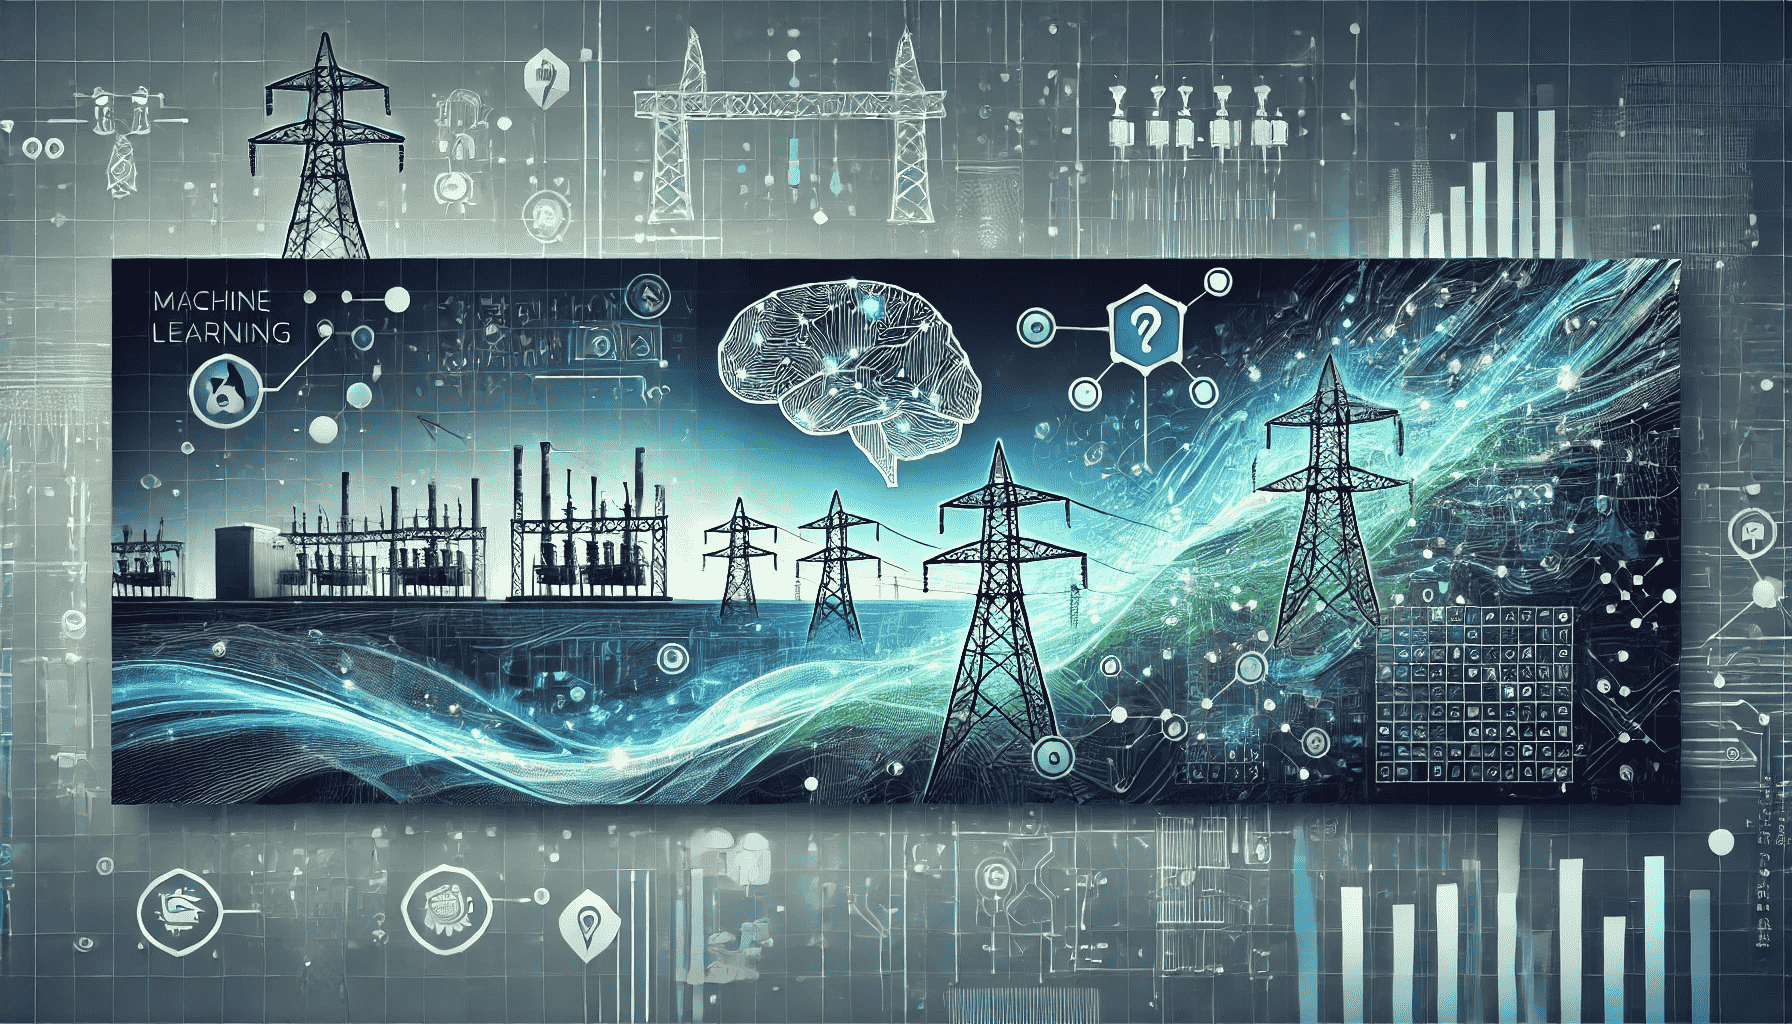

# Forecasting Electric Load Using Multi-Output Supervised Machine Learning

The functioning of any electrical grid requires forecasts of the expected load. Electricity cannot be stored in significant quantities. Thus, producers such as gas and oil plants need to know how much electricity they need to generate to cover the expected load. Moreover, because turning large generators on and off takes time and resources, scheduling must be done in advance. Therefore, electrical load must be forecasted several hours or even days ahead.

There are several horizons on which electrical load can be forecasted. For instance, a new factory or a large residential area that will be opened next year must be included in long-term load forecasts so that energy providers are prepared when a new consumer appears. On shorter time horizons, the load depends on the maintenance schedules of various consumers and on climate conditions. For instance, a very cold day will see an increased load as electric heaters are turned on. These short-term forecasts are crucial, as accurate forecasts allow electric grid operators and more intermittent energy generators, such as solar and wind farms, to balance the grid more efficiently.

In this notebook, we explore how electrical load can be forecasted for 3 days ahead using historical data on electrical generation and load for the past 11 years. The data was downloaded from SMARD via API. 

## Part 1: EDA
First, we load the data donloaded from SMARD. The data starts at 2015-01-01 at 00:00 and ends on 2024-09-18 at 23:00. For simplicity the timezone is set to be UTC. Note, that when you download data from SMARD it will be in a local German timezone (CET/CEST).  

Our goal here is to forecast a given variable beyond the time range available in the dataframe.  
We need to be sure that the dataframe has consistently hourly data. If there are gaps or duplicates -- they need to be addressed. 

In [1]:
import pandas as pd
df = pd.read_csv('/kaggle/input/german-electrical-load-2015-2024/dataframe.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True) # set index 
# get the dataframe frqeuency
time_diffs = df.index.to_series().diff().dropna().unique()
if (time_diffs == '1 hours').all():
    print("Dataframe has hourly data")
    df = df.asfreq('h')

Dataframe has hourly data


In our case the dataframe has a consistent hourly frequency. 

In [2]:
df.tail()

,biomass,hydropower,wind_offshore,wind_onshore,solar,other_renewables,nuclear_energy,lignite,hard_coal,natural_gas,pumped_storage,other_conventional,realized_load
date,,,,,,,,,,,,,
2024-09-18 19:00:00+00:00,1024.4375,500.9375,502.4375,5301.9375,0.0,26.25,0.0,2256.6875,911.8125,1011.9375,154.0625,333.9375,13318.5625
2024-09-18 20:00:00+00:00,1004.4375,497.1250,507.5000,4979.1875,0.0,26.25,0.0,2271.5625,775.3125,892.6250,35.0625,329.5000,12422.3750
2024-09-18 21:00:00+00:00,997.4375,490.0625,417.5000,4619.7500,0.0,26.25,0.0,2276.6250,638.1250,756.3125,34.0000,330.5000,11449.9375
2024-09-18 22:00:00+00:00,1001.4375,481.6250,347.6250,4195.6250,0.0,26.25,0.0,2272.0000,518.3125,775.2500,28.0000,316.7500,10725.0625
2024-09-18 23:00:00+00:00,1014.9375,472.7500,299.4375,3771.3750,0.0,26.25,0.0,2266.4375,411.5625,699.5625,5.2500,310.2500,10379.3125


The data includes energy generated at a given hour by different sources aggregated by technology. Specifically, we have the following


In [3]:
df.columns

Index(['biomass', 'hydropower', 'wind_offshore', 'wind_onshore', 'solar',
       'other_renewables', 'nuclear_energy', 'lignite', 'hard_coal',
       'natural_gas', 'pumped_storage', 'other_conventional', 'realized_load'],
      dtype='object')

where the last column is the target variable we want to forecast. 

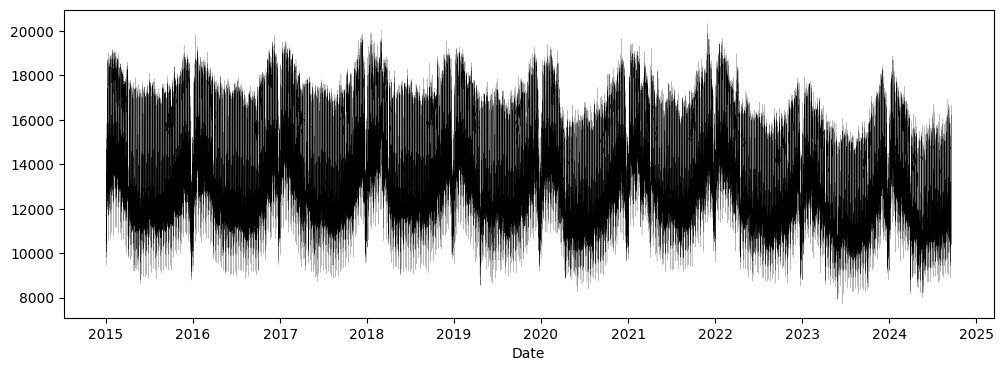

In [4]:
target = 'realized_load'
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, df[target], lw=0.1, color='black', label='Realized Load')
ax.set_xlabel("Date")
plt.show()

The figure shows that realized load, the quantity we want to forecast, has a strong periodic behaviour. Moreover, it is possible that this time series is stationary. Stationarity is a key property that allows us to use autoregressive forecasting methos, such as ARIMA. However, in this example we will not consider those for bravity. 

__NOTE__: here, for simplicity, we do not perform the following important steps:
- Target varaible seasonal decomposition analysis;
- Auto-correlation and partial auto-correlation analysis;
- Principle component analysis.

We leave them to a more substantial later analysis. Here we focus on forecasting. 

## Part 2: Forecasting
Instead of classical forecasting tools such as moving averages and autoregressive methods, here we will employ a machine learning model. The reason for this is that we want to take advantage not only of the past values of a target variable to predict its future values, but also of other variables that may affect the target variable. For instance, in the energy grid, generation and load are tightly connected. High expected availability of solar and wind power (due to predicted weather conditions) can drive up the load. Conversely, low expected generation may lead to a lower load. In fact, the electrical grid increasingly depends on weather conditions as the fraction of renewables increases. While we do not include weather variables here for simplicity, the generality of our model allows us to do so with ease, and we leave this as an exercise.

### Multi-output Forecasting
As established earlier, we need to forecast the target variable for several days ahead. There are several techniques that allow forecasting multiple timestamps:

- __Direct Multi-step Forecast__: This method involves developing separate models for each forecast horizon. For instance, if you are forecasting for 1, 2, and 3 hours ahead, you would create three distinct models, each trained to predict the target variable at 1 hour, 2 hours, and 3 hours into the future, respectively.
- __Recursive Multi-step Forecast__: In this approach, a single model is used to make predictions one step at a time. The prediction for the first future time step is used as input to help forecast the next time step, and this process is repeated for as many steps as needed.
- __Multi-Output Forecasting__: In this approach, the model is designed to output multiple forecast points in one go. This is particularly useful when the future values being predicted are interdependent, meaning that the forecasts for each point could potentially improve by being predicted together rather than separately.

All of these approaches have advantages and disadvantages. Arguably, multi-output forecasting is more complex in both implementation and interpretation. However, it offers better performance and does not suffer from propagating errors as much as recursive forecasting. The key features of the method are:

- __Single Model for Multiple Outputs__: Unlike direct or recursive multi-step forecasting methods, where each time step might be modeled separately, multi-output forecasting uses one model to predict all future time steps in the target window simultaneously.
- __Training Targets as Vectors or Matrices__: The target variable in the training data is structured as a vector (for one-dimensional time series) or a matrix (if there are multiple parallel time series or features), where each element corresponds to a future time step.
- __Considers Interdependencies__: This method can be more effective in capturing the dependencies between the forecasted values across different time steps.

### Feature engineering

We begin by adding cyclical time features that will help the model to learn correlations between the target and the time.  

## Part 1: EDA
First, we load the data donloaded from SMARD. The data starts at 2015-01-01 at 00:00 and ends on 2024-09-18 at 23:00. For simplicity the timezone is set to be UTC. Note, that when you download data from SMARD it will be in a local German timezone (CET/CEST).  

Our goal here is to forecast a given variable beyond the time range available in the dataframe.  
We need to be sure that the dataframe has consistently hourly data. If there are gaps or duplicates -- they need to be addressed. 

In [5]:
import numpy as np
df['day_of_week_sin'] = np.sin(2 * np.pi * (df.index.dayofweek + 1) / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * (df.index.dayofweek + 1) / 7)

# Encoding hours (for completeness, assuming all times at 00:00)
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)

# Encoding month of the year
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

# Encoding day of the month, using the last day of each month to find the cycle end
df['day_sin'] = df.index.map(lambda x: np.sin(2 * np.pi * x.day / x.days_in_month))
df['day_cos'] = df.index.map(lambda x: np.cos(2 * np.pi * x.day / x.days_in_month))

### Scaling

Scaling, or mapping the data to a certain range, is very important in machine learning because numerical differences can make it difficult for a model to handle large discrepancies in the values of different features effectively. Notably, XGBoost, which we will use here, does not require scaling, unlike most other gradient boosting and decision tree-based algorithms. However, it is good practice to perform normalization, which can be useful for future development of the analysis.

Here, we scale each feature and the target columns independently. In other words, each column of the original dataframe will have its own scaler.

In [6]:
from sklearn.preprocessing import MinMaxScaler
def scale_df(X: pd.DataFrame):
    X_scaled = X.copy(deep=True)
    scalers = {column: MinMaxScaler() for column in df.columns}
    for column, scaler in scalers.items():
        X_scaled[column] = scaler.fit_transform(df[[column]])
    return X_scaled, scalers
def unscale_col(col: np.ndarray, scaler: MinMaxScaler):
    # col is an array of shape (num_samples, n_outputs)
    # We need to inverse_transform each column
    # Since scaler expects 2D array, we can reshape accordingly
    return scaler.inverse_transform(col)
scaled_df, scalers = scale_df(df)

### Data preparation

Multi-output forecasting requires a significant degree of data manipulation. 
Specifically, the multivariate time-series data needs to be transformed into a series, a list, of training examples. Each example should contain an X-matrix and y-vector. The X-matrix should be composed of all the data points and all the feature values that the model should learn to correspond to the y-vector of target variables. 

Here, we introduce two key parameters: history length and horizon length. 
- History length determines how many timesteps model should learn to correspond to the target. It determines the size of X-matrixes. 
- Horizon length defines how many timestamps a model should be able to forecast in one go. It sets the size of y-vectors. 

Generally it is expected that the history size is larger than the horizon size. The intuition is that the model should be have access to longer window of information to be able to predict new data. 

Building feature-target or X-y pairs with two lengths in mind can be imagined as scanning the dataframe with a fixed-sized window. The figure below attempts to illustrate that:

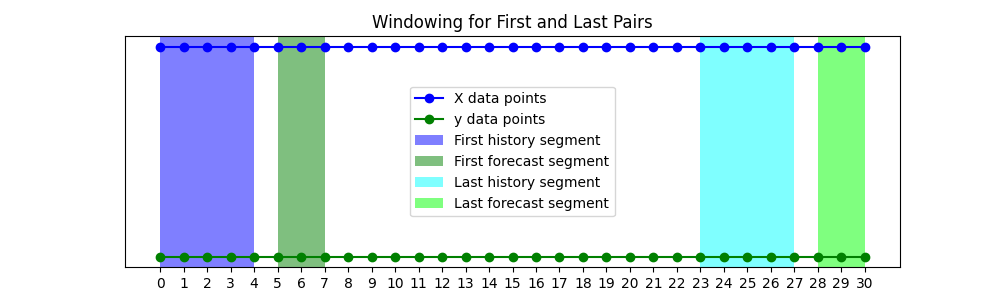

There the time-series dataset is shown as dotted line and X-y pairs are shown as blue-green or cyan-lime boxes. For clarity, only the first and the last samples are shown. The sizes of boxes correspond to the history (blue or cyan) and horizon (green or lime) lengths respectively.   
The first part starts at the first datapoint for X but at the 0 + history length for y. This is shown in the figure as a distinct boundary between the green and the blue box. 

The next X-y pair can start either at the next datapoint (i.e., it will overlap with the previous one) or using a specified stride. Here, for simplicity, we shift the window by 1 (i.e., with overlaps).  

The last X-y pair is shown in the figure in cyan-lime colors. Note that while the y-vector reaches the end of the data available, the X-matrix stops at the horizon length distance from the end. This means that there are unused feature values. One can already guess that these feature values will be used to make the forecast for the future, to produce y-vectors that lay outside of the available data

In the following code, we partition the data frame into examples of X-matrixes and y-vectors. We will do so, as per convention, for training, validation, and test sets.  


In [7]:
def windowing_train(idx, X_input, y_input, history_size, forecast_horizon):
    """
        generate pairs: feature target for supervised learning
        The pairs are generated as following. Given sets of X and y as
            if X [ 0 1 2 3 4 5 7 . . . N ]
            and y [ 0 1 2 3 4 5 7 . . . N ]
        the X_input data is split into blocks of size 'history_size' while the y_input is
        split into blocks of size 'forecast_horizon'

        Example:
            the first split is done as follows:
            data_0 = X_input[0 : history_size]
            label_0 = y_input[history_size : history_size + forecast_horizon]
        Note that first 'history_size' number of y_input is not used here

        Example:
            the last split is done as follows:
            data_N = X_input[len(y_input)-forecast_horizon+1-history_size : len(y_input)-forecast_horizon+1]
            label_N = y_input[len(y_input)-forecast_horizon+1 : len(y_input)+1]
        Note: the last possible X_input[len(y_input)+1-history_size : len(y_input)+1] is not used here
        as it does not have corresponding label
    """
    data = []
    labels = []
    idexes = []
    for i in range(history_size, len(y_input)-forecast_horizon+1):
        data.append(X_input[i - history_size : i, :])
        idexes.append(idx[i : i + forecast_horizon])
        labels.append(y_input[i : i + forecast_horizon].flatten())
        # print(f"i={i} X[{i-history_size} : {i}] Y[{i} : {i+forecast_horizon}] Size len(y)={len(y_input)}")
    return np.array(data), np.array(labels), idexes

def windowing_pred(idx, X_input, y_input, history_size, forecast_horizon):
    """
        generate pairs: feature target for supervised learning (for the last data entries that do not
        have corresponding labels)
        The pairs are generated as following. Given sets of X and y as
            if X [ 0 1 2 3 4 5 7 . . . N ]
            and y [ 0 1 2 3 4 5 7 . . . N ]
        Example:
            the last split is done as follows:
            data_N = X_input[len(y_input)-forecast_horizon+1 : len(y_input)]
    """
    data_last = []
    indexes_last = []
    for i in range(len(y_input)-forecast_horizon+1, len(y_input)):
        # i = len(y_input)
        data_last.append(X_input[i - history_size : i, :])
        indexes_last.append( pd.date_range(start=idx[i]+pd.Timedelta(hours=1), periods=forecast_horizon-1, freq='h') )
        # print(f"LAST: i={i} X[{i-history_size} : {i}] Size len(y)={len(y_input)}")
    return np.array(data_last), indexes_last

In [8]:
index = df.index # time column for plotting

# separate features and target for supervised learning
X = scaled_df.drop([target], axis=1)
features = X.columns.to_list()
X = X.values
y = scaled_df[[target]].values

# create train-validation and validation-test splits
train_cutoff, valid_cutoff = 0.85, 0.98
train_cutoff = int(train_cutoff * X.shape[0])
valid_cutoff = int(valid_cutoff * X.shape[0])


# use past (lagged) target as a feature (e.g., aka autoregressive)
data_norm = np.concatenate((X, y), axis=1)
features.append(target+"_lagged")

hist_size = 30*24 # one month data
forecast_horizon = 4*24 # 4 days to forecast
X_train, y_train, i_train = windowing_train(
    index[:train_cutoff], data_norm[:train_cutoff, :],
    data_norm[:train_cutoff, -1], hist_size, forecast_horizon
)
X_val, y_val, i_val = windowing_train(
    index[train_cutoff:valid_cutoff],
    data_norm[train_cutoff:valid_cutoff, :],
    data_norm[train_cutoff:valid_cutoff, -1],
    hist_size, forecast_horizon
)
X_test, y_test, i_test = windowing_train(
    index[valid_cutoff:], data_norm[valid_cutoff:, :],
    data_norm[valid_cutoff:, -1], hist_size, forecast_horizon
)
X_last, i_last = windowing_pred(
    index, data_norm, data_norm[:, -1], hist_size, forecast_horizon
)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(71584, 720, 21) (10258, 720, 21) (889, 720, 21)
(71584, 96) (10258, 96) (889, 96)


Note that X_train, X_val, and X_test are 3D arrays with the first axis representing different examples of the X-y or, the second axis showing history length, and the final axis standing for different features in our dataset.  
Meanwhile, y_train, y_val, and y_test are 2D arrays with the first axis being as in the X case -- different examples, but the second axis indicates the horizon length.  
The ML model will learn to correspond to the history-sized X-matric with a horizon-sized y-vector.  

Also note that, for simplicity, X_last, which corresponds to the ending of the data frame, is produced separately. This X-matrix does not have a corresponding y-vector. This is what we will forecast.  

### Training

Before we can train the model, we need to convert 3D arrays for X-matrixes and 2D arrays for y-vectors into 2D X-matrixes and 1D vectors. Thus, we effectively 'collapse' all our history and horizon axes with feature lengths. 

After that we can train the XBGoost model on the data. This will take a while. So we load pre-trained model for brevity. 

In [9]:
import xgboost as xgb
import joblib
def reshaping(X):
    reshaped_x = X.reshape(-1, X.shape[1] * X.shape[2])
    return reshaped_x
X_train_xgb = reshaping(X_train)
X_val_xgb = reshaping(X_val)
X_test_xgb = reshaping(X_test)
X_last_xgb = reshaping(X_last)

train=False # we have already pre-trained the model
fname = '/kaggle/input/xdg_german_eload_h30_f4/scikitlearn/default/1/xdb_h30_f4.joblib'
if train:
    print("Training XGBoost model")
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror'
    )
    xgb_model.fit(
        X_train_xgb, y_train,
        eval_set=[
            (X_train_xgb, y_train),
            (X_val_xgb, y_val)
        ],
        eval_metric='mae',
        early_stopping_rounds=8,
        verbose=False)
    # save model
    joblib.dump(xgb_model, fname)
else:
    xgb_model = joblib.load(fname)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:21:01] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


Also, for brevity, no hyperparameter search was done here. We leave this to future works. 

### Assessing model performance

Several metrics can be used to assess the model's performance. Here, we consider mean-absolute-error, mean-squared-error, and R2 score. However, before we compute those metrics, the data needs to be scaled back. 

In [10]:
from sklearn.metrics import (mean_absolute_error,mean_squared_error,r2_score)
print("Inference on the test set")
y_pred = xgb_model.predict(X_test_xgb)
y_pred_actual = unscale_col(y_pred, scalers[target])
y_test_inv = unscale_col(y_test, scalers[target])

# compute error metrics
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('---------------------------------------------------')
print(f'MAE={mae:.4f} MSE={mse:.4f} R2={r2:.4f}')
print('---------------------------------------------------')


Inference on the test set
---------------------------------------------------
MAE=0.0276 MSE=0.0013 R2=0.9473
---------------------------------------------------


Metrics suggest that the model performance is good, but there is room for improvement.  
Additionally, electrical grid operators and TSOs publish their own load forecasts, and these forecasts can be compared with theirs.  
The model can be improved via 
- Using more features, such as weather features (both historical and forecasts) 
- Hyperparameter search 
- Other ML algorithms (LSTM, hybrids)

### Feature Importance

A useful feature of gradient-boosting algorithms is that they, by default, provide feature importance analysis. This allows us to access how strongly a given feature affected the result. Notably, because we had to collapse the history length and number of features axeses, we needed to expand them first. 

In [11]:
# XGB feature importances
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features, 'Importance': feature_importances.reshape(hist_size,len(features)).sum(axis=0)}
).sort_values(by='Importance', ascending=False)
print("XGB feature importances:")
print(importance_df.to_string(index=False))

XGB feature importances:
             Feature  Importance
realized_load_lagged    0.646427
           month_cos    0.082747
             day_cos    0.049956
           month_sin    0.036376
             day_sin    0.029762
               solar    0.024278
    other_renewables    0.013493
           hard_coal    0.013108
      nuclear_energy    0.012808
         natural_gas    0.012641
             lignite    0.012261
        wind_onshore    0.011769
          hydropower    0.011269
  other_conventional    0.011239
       wind_offshore    0.010130
             biomass    0.008888
     day_of_week_sin    0.004928
     day_of_week_cos    0.003803
      pumped_storage    0.003539
            hour_cos    0.000297
            hour_sin    0.000281


The analysis shows that the lagged target variable is the most important one. This confirms our original observation of the target variable's strong autoregressive behavior.  
Notably, this feature importance analysis may be biased to a specific arrangement of features in the dataset. In order to alleviate it, a "permutation feature importance" [(link)](https://scikit-learn.org/stable/modules/permutation_importance.html) analysis is needed. We leave this to future works. 

### Forecasting into the future

Finally, we can forecast the data beyond the available range. This is what energy produces, and consumers can both use to plan their operations.  
Recall, that we are forecasting a horizon-length of data for each X-matrix. Moreover, recall that our X-matrixes overlap. Thus, in visualizing the result, we have a choice of which element from the horizon length to display. We plot the last hour of each forecasted block (i=-1) 

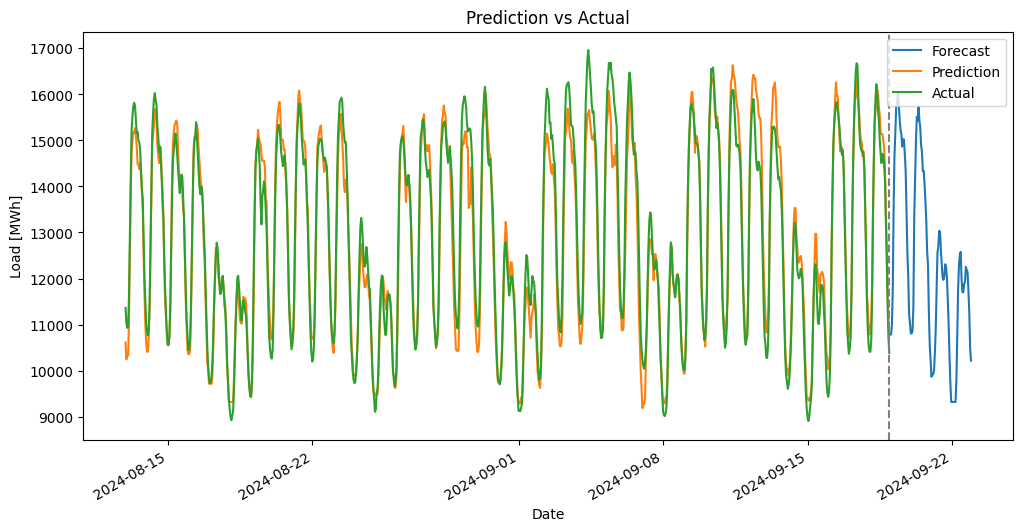

In [12]:
i = -1 # which element in the datablock to show

# predict target for last features in the dataset
y_pred_last = xgb_model.predict(X_last_xgb)
y_pred_last_actual = unscale_col(y_pred_last, scalers[target])

# plot the result
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot([d[i] for d in i_last], y_pred_last_actual[:,i], label='Forecast')
ax.plot([d[i] for d in i_test], y_pred_actual[:,i], label='Prediction')
ax.plot([d[i] for d in i_test], y_test_inv[:,i], label='Actual')
ax.axvline(x=df.index[-1], color='gray', linestyle='--')
ax.legend()
ax.set_title(f'Prediction vs Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Load [MWh]')
fig.autofmt_xdate()
plt.show()

The figure shows that while our model is capable of reproducing most of the periodicities seen in the data (hourly, daily, weekly), it struggles to capture the exact amplitudes. This further suggests that the model can be improved with either more fine-tuning or with more features. Overall, however, this model performs significantly better than the iterative forecasting models we explored. Specifically, an iterative LSTM model, while able to forecast the first several hours reasonably well, showed a tendency to explode the longer the forecasting horizon was. 